# GP Applied to the Even-Parity Problem

This time we apply GP to a Boolean problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP.

In [14]:
!pip install deap

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [16]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [17]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10


Set the random seed.

In [18]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [19]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [20]:
NUM_INPUTS = 3
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [21]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [22]:
pset1 = gp.PrimitiveSet("PSET1", 3)
pset1.addPrimitive(operator.add, 2)
pset1.addPrimitive(operator.sub, 2)
pset1.addPrimitive(operator.mul, 2)

pset2 = gp.PrimitiveSet("PSET2", 3)
pset2.addPrimitive(operator.and_, 2)
pset2.addPrimitive(operator.not_, 1)
pset2.addPrimitive(operator.xor, 2)

pset3 = gp.PrimitiveSet("PSET3", 3)
pset3.addPrimitive(operator.and_, 2)
pset3.addPrimitive(operator.or_, 2)
pset3.addPrimitive(operator.not_, 1)

# add terminal values:
pset1.addTerminal(1)
pset1.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

### 1

In [23]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset1, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset1)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset1)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Set up our population as before

In [24]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [25]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size.

In [26]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std    	avg   	gen	max	min	nevals	std    
0  	2000  	5.7905	0  	8  	2  	2000  	1.36514	36.656	0  	63 	15 	2000  	20.0896
1  	1820  	5.165 	1  	8  	2  	1820  	1.21564	34.458	1  	93 	1  	1820  	19.885 
2  	1793  	4.744 	2  	8  	1  	1793  	1.0712 	32.513	2  	95 	1  	1793  	19.595 
3  	1792  	4.495 	3  	8  	2  	1792  	0.94867	31.923	3  	101	1  	1792  	19.4829
4  	1790  	4.306 	4  	8  	2  	1790  	0.837475	32.4  	4  	107	1  	1790  	19.6927
5  	1807  	4.2085	5  	8  	2  	1807  	0.815492	33.629	5  	117	1  	1807  	20.6397
6  	1779  	4.141 	6  	8  	2  	1779  	0.738322	34.487	6  	115	1  	1779  	21.5287
7  	1794  	4.0975	7  	8  	2  	1794  	0.754317	35.164	7  	127	1  	1794  	21.9774
8  	1804  	4.059 	8  	8  	2  	1804  	0.733157	35.723	8  	141	1  	1804  

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  or_(and_(or_(not_(and_(or_(ARG1, and_(ARG2, ARG0)), or_(and_(ARG0, not_(or_(ARG0, ARG0))), or_(ARG0, ARG2)))), and_(and_(and_(ARG0, ARG2), and_(ARG2, ARG2)), not_(not_(ARG1)))), ARG0), and_(not_(or_(ARG0, and_(ARG1, or_(ARG0, ARG2)))), or_(ARG2, and_(or_(ARG2, or_(and_(ARG2, ARG0), ARG1)), or_(not_(or_(and_(and_(or_(and_(and_(not_(not_(or_(not_(not_(ARG1)), ARG1))), not_(ARG1)), not_(or_(ARG0, ARG0))), and_(or_(ARG0, ARG0), not_(and_(ARG2, and_(ARG1, ARG2))))), ARG1), ARG1), or_(ARG2, or_(or_(ARG0, ARG0), and_(ARG2, ARG1))))), ARG1)))))
-- length=94, height=17
-- Best Fitness =  0.0


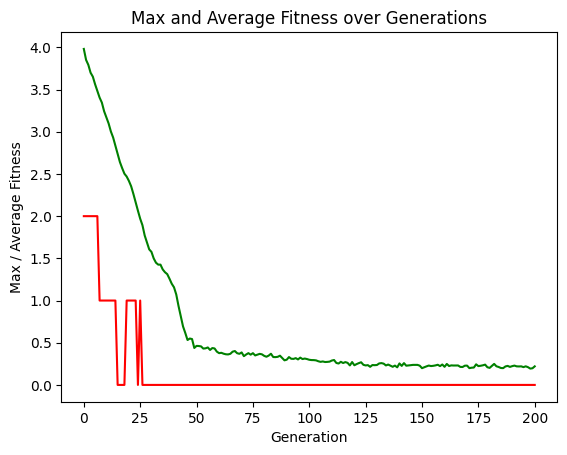

In [36]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
meanSize1 = logbook.chapters['size'].select("avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

### PSET 2

In [28]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset2, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset2)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset2)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



In [29]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std    	avg    	gen	max	min	nevals	std    
0  	2000  	4.0005	0  	8  	0  	2000  	1.04952	19.7875	0  	58 	4  	2000  	11.5933
1  	1819  	3.769 	1  	8  	0  	1819  	0.998318	20.4365	1  	65 	1  	1819  	12.09  
2  	1773  	3.6765	2  	8  	0  	1773  	1.03916 	20.9045	2  	78 	1  	1773  	12.242 
3  	1819  	3.6425	3  	8  	0  	1819  	1.11117 	22.4045	3  	81 	1  	1819  	13.279 
4  	1824  	3.555 	4  	8  	0  	1824  	1.15151 	23.6625	4  	78 	1  	1824  	13.4912
5  	1846  	3.4315	5  	8  	0  	1846  	1.19261 	25.0015	5  	81 	1  	1846  	14.7795
6  	1808  	3.3405	6  	8  	0  	1808  	1.20522 	26.3545	6  	100	1  	1808  	15.5363
7  	1789  	3.2565	7  	8  	0  	1789  	1.27895 	28.0585	7  	100	1  	1789  	16.1182
8  	1814  	3.126 	8  	8  	0  	1814  	1.33421 	30.646 	8  	9

-- Best Individual =  or_(and_(or_(not_(and_(or_(ARG1, and_(ARG2, ARG0)), or_(and_(ARG0, not_(or_(ARG0, ARG0))), or_(ARG0, ARG2)))), and_(and_(and_(ARG0, ARG2), and_(ARG2, ARG2)), not_(not_(ARG1)))), ARG0), and_(not_(or_(ARG0, and_(ARG1, or_(ARG0, ARG2)))), or_(ARG2, and_(or_(ARG2, or_(and_(ARG2, ARG0), ARG1)), or_(not_(or_(and_(and_(or_(and_(and_(not_(not_(or_(not_(not_(ARG1)), ARG1))), not_(ARG1)), not_(or_(ARG0, ARG0))), and_(or_(ARG0, ARG0), not_(and_(ARG2, and_(ARG1, ARG2))))), ARG1), ARG1), or_(ARG2, or_(or_(ARG0, ARG0), and_(ARG2, ARG1))))), ARG1)))))
-- length=94, height=17
-- Best Fitness =  0.0


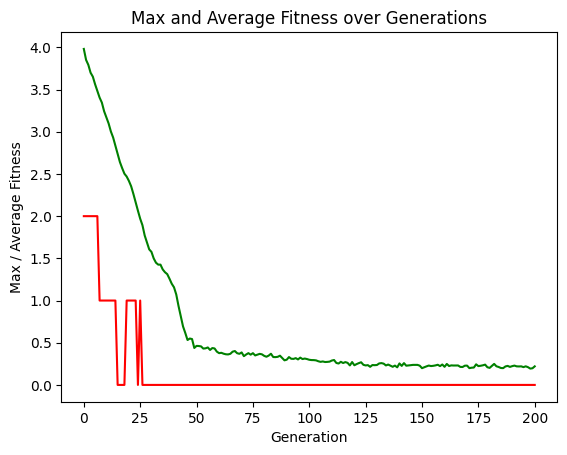

In [37]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
meanSize2 = logbook.chapters['size'].select("avg")



# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

### 3

In [31]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset3, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset3)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset3)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



In [32]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)


   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std    
0  	2000  	3.982	0  	6  	2  	2000  	0.577647	19.4165	0  	58 	4  	2000  	11.3838
1  	1807  	3.852	1  	6  	2  	1807  	0.546897	19.1665	1  	71 	1  	1807  	11.5368
2  	1810  	3.793	2  	6  	2  	1810  	0.574588	19.8365	2  	75 	1  	1810  	12.1455
3  	1759  	3.7  	3  	6  	2  	1759  	0.594138	21.4425	3  	81 	1  	1759  	12.5409
4  	1785  	3.653	4  	6  	2  	1785  	0.616921	23.261 	4  	74 	1  	1785  	13.2649
5  	1792  	3.563	5  	6  	2  	1792  	0.628515	24.968 	5  	77 	1  	1792  	13.7222
6  	1811  	3.484	6  	5  	2  	1811  	0.63698 	27.276 	6  	92 	1  	1811  	14.9597
7  	1779  	3.405	7  	6  	1  	1779  	0.641853	29.3065	7  	108	1  	1779  	15.5818
8  	1805  	3.346	8  	6  	1  	1805  	0.671777	32.436 	8  	91 	1  

-- Best Individual =  or_(and_(or_(not_(and_(or_(ARG1, and_(ARG2, ARG0)), or_(and_(ARG0, not_(or_(ARG0, ARG0))), or_(ARG0, ARG2)))), and_(and_(and_(ARG0, ARG2), and_(ARG2, ARG2)), not_(not_(ARG1)))), ARG0), and_(not_(or_(ARG0, and_(ARG1, or_(ARG0, ARG2)))), or_(ARG2, and_(or_(ARG2, or_(and_(ARG2, ARG0), ARG1)), or_(not_(or_(and_(and_(or_(and_(and_(not_(not_(or_(not_(not_(ARG1)), ARG1))), not_(ARG1)), not_(or_(ARG0, ARG0))), and_(or_(ARG0, ARG0), not_(and_(ARG2, and_(ARG1, ARG2))))), ARG1), ARG1), or_(ARG2, or_(or_(ARG0, ARG0), and_(ARG2, ARG1))))), ARG1)))))
-- length=94, height=17
-- Best Fitness =  0.0


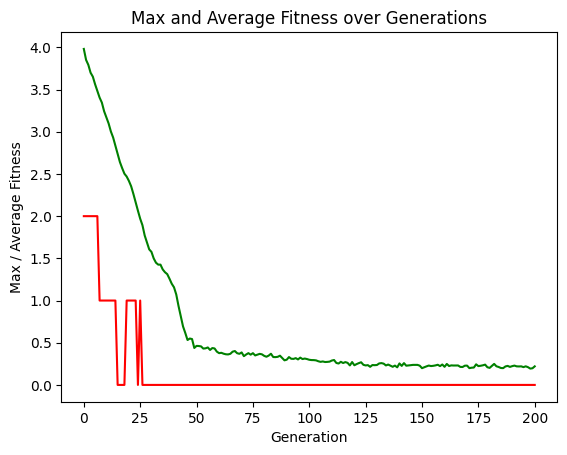

In [38]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
meanSize3 = logbook.chapters['size'].select("avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

In [40]:
### Comparing Average Sizes

print("Mean Size of Set 1: ", numpy.mean(meanSize1))
print("Mean Size of Set 2: ", numpy.mean(meanSize2))
print("Mean Size of Set 3: ", numpy.mean(meanSize3))

Mean Size of Set 1:  147.6241517412935
Mean Size of Set 2:  147.6241517412935
Mean Size of Set 3:  147.6241517412935
